In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
from nilearn import plotting

from src import data,centroids,labels

from netneurotools import metrics
    # https://netneurotools.readthedocs.io/en/latest/, pip install netneurotools does not work for me
    # I downloaded the repository and I am using the local copy

%matplotlib inline

!date -I

2024-05-03


## Settings

In [2]:
parcellations = {"DKT","MNI-HCP-MMP1"} # MNI-HCP-MMP1 is another name for Glasser parcellation

# following ROIs are not present in enigma with DKT parcellation,
# so it should be deleted from responses to have matching dimensions
ids_to_delete_in_dkt = [37,3] 

# set parecallation to use for structural connectivity
# availible parcellations listed above
PARCELLATION =  "DKT"
AMPLITUDE_MASK_SAME_AS_PROBABILITY_MASK = False


if PARCELLATION not in parcellations:
    print(f"Selected parcellation {PARCELLATION} not in availible parcellations!")

fig_dir = "comparing_sc_matrices/"

## Load data

### Load F-TRACT data

In [3]:
# F-TRACT dataset is availible in several parcellations, select and load the one defined above
ftract_labels = data.load_ftract_labels(PARCELLATION)

### Load structural (and functional) connectivity data

In [20]:
SC_matrices = []

if PARCELLATION == "DKT":
    ED = centroids.dkt_roi_distances()
    SC_matrices = data.load_set_of_DKT_matrices_for_ftract(ids_to_delete_in_dkt,ED)

elif PARCELLATION == "MNI-HCP-MMP1":
    labels = data.ftract_compatible_glasser_labels()
    centroid_coors = centroids.load_glasser_centroids(ftract_labels=ftract_labels)
    ED = centroids.glasser_roi_distances(ftract_labels=ftract_labels)

    SC_matrices = data.load_set_of_glasser_matrices_for_ftract(ftract_labels,ED=ED)

elif PARCELLATION == "schaefer":
    centroid_coors = centroids.get_centroids_from_file
    ED = data.glasser_roi_distances(ftract_labels=ftract_labels)

    SC_matrices = data.load_set_of_schaefer_matrices_for_pytepfit()  

number_of_SC = len(SC_matrices)

SyntaxError: expected ':' (3211354246.py, line 14)

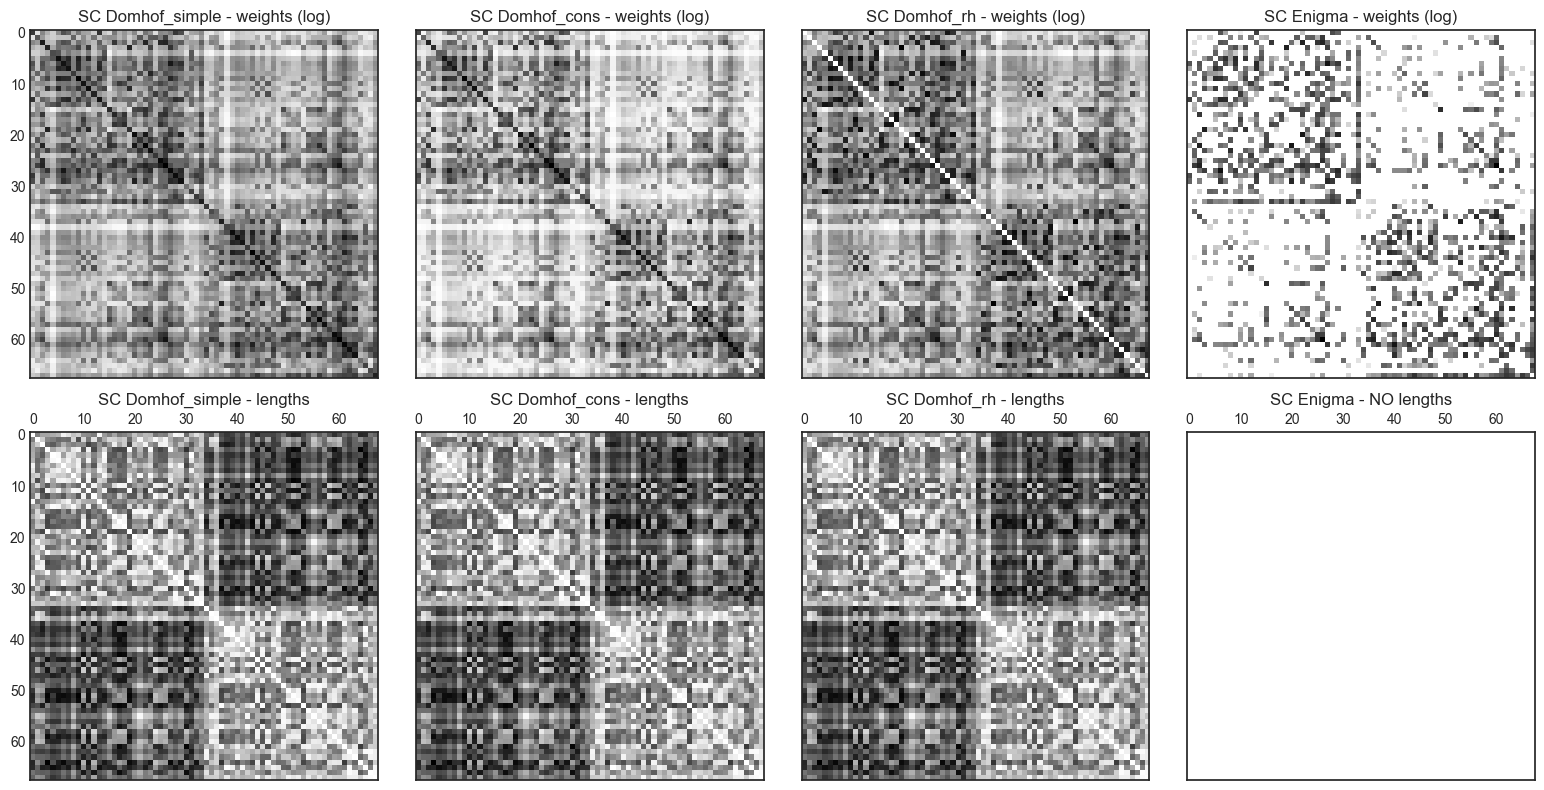

In [5]:
plt.rcParams['figure.figsize'] = [4*number_of_SC,8]
plt.style.use('seaborn-v0_8-white')

fig, axs = plt.subplots(2,number_of_SC, tight_layout=True,sharex=True,sharey=True)

for i in range(number_of_SC):
    name, SC_W, SC_L, SC_W_log = SC_matrices[i]

    axs[0,i].matshow(SC_W_log)
    axs[0,i].set_title(f"SC {name} - weights (log)")

    if SC_L is not None:
        axs[1,i].matshow(SC_L)
        axs[1,i].set_title(f"SC {name} - lengths")
 
    else:
        axs[1,i].matshow(np.zeros(SC_W.shape))
        axs[1,i].set_title(f"SC {name} - NO lengths")

plt.savefig(paths.path_figures(fig_dir+"sc_matrices.pdf"))

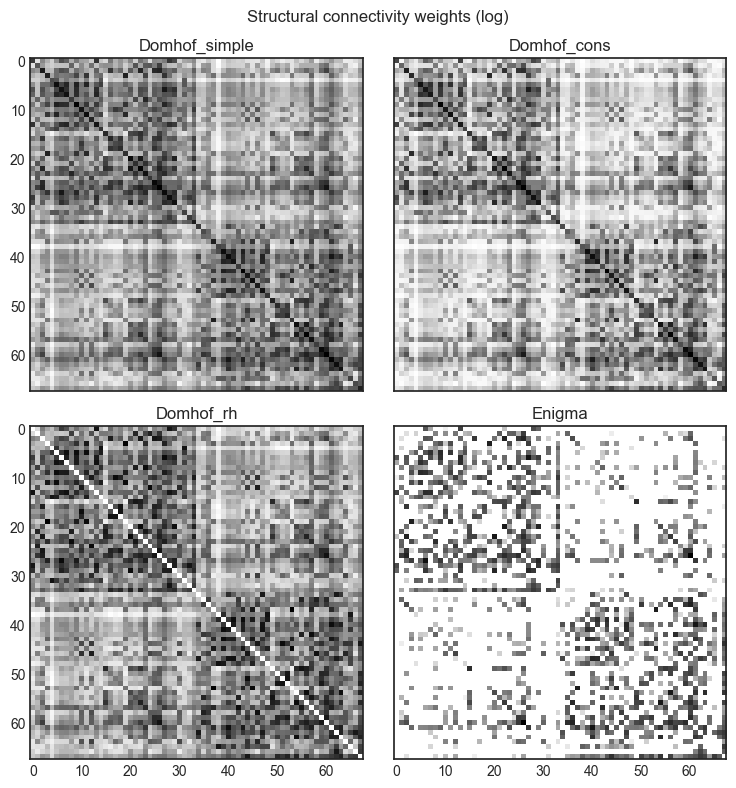

In [6]:
plt.rcParams['figure.figsize'] = [8,8]
plt.style.use('seaborn-v0_8-white')

fig, axs = plt.subplots(2,2, tight_layout=True,sharex=True,sharey=True)

axs[0,0].matshow(SC_matrices[0][3])
axs[0,0].set_title(f"{SC_matrices[0][0]}")

axs[0,1].matshow(SC_matrices[1][3])
axs[0,1].set_title(f"{SC_matrices[1][0]}")

axs[1,0].matshow(SC_matrices[2][3])
axs[1,0].set_title(f"{SC_matrices[2][0]}")

axs[1,1].matshow(SC_matrices[3][3])
axs[1,1].set_title(f"{SC_matrices[3][0]}")

axs[1,1].tick_params(top=False, labeltop=False, bottom=True, labelbottom=True)
axs[1,0].tick_params(top=False, labeltop=False, bottom=True, labelbottom=True)

plt.suptitle(f"Structural connectivity weights (log)")

plt.savefig(paths.path_figures(fig_dir+"sc_matrices_thesis.pdf"),bbox_inches='tight',pad_inches=0)

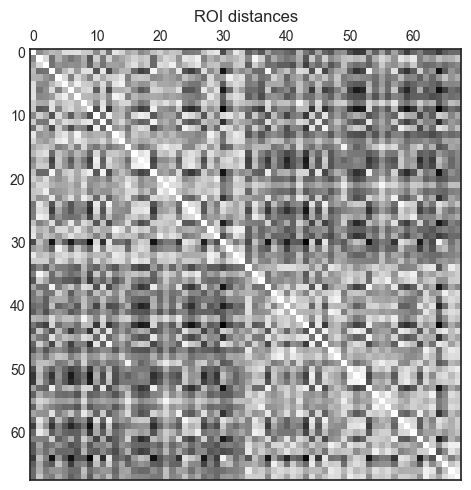

In [7]:
if ED is not None:
    plt.rcParams['figure.figsize'] = [5,5]
    fig, axs = plt.subplots(1, 1, tight_layout=True)
    axs.matshow(ED)
    axs.set_title("ROI distances")

In [8]:
plt.style.use('ggplot')

In [9]:
df_weights = pd.DataFrame()
df_lengths = pd.DataFrame()

for name, SC_W, SC_L, SC_W_log in SC_matrices:
    df_weights[name] = SC_W.flatten()
    if SC_L is not None:
        df_lengths[name] = SC_L.flatten()

In [10]:
def minmax_norm(column):
    return (column - column.min()) / (column.max() - column.min())

In [11]:
columns = list(df_weights.columns)

df_weights_normalized = df_weights.copy()

for col in columns:
    df_weights_normalized[col] = minmax_norm(df_weights_normalized[col])
df_weights_normalized

,Domhof_simple,Domhof_cons,Domhof_rh,Enigma
0,0.000000,0.000000,0.000000,0.000000
1,0.000020,0.000039,0.000096,0.000000
2,0.003549,0.003549,0.006686,0.000000
3,0.000446,0.000448,0.001148,0.000000
4,0.000075,0.000105,0.000455,0.000000
...,...,...,...,...
4619,0.183053,0.183053,0.240303,0.073320
4620,0.003611,0.003611,0.009267,0.001568
4621,0.034407,0.034407,0.083633,0.094337
4622,0.040479,0.040479,0.103179,0.025934


In [12]:
df_weights.astype(bool).sum(axis=0)

Domhof_simple    4556
Domhof_cons      4556
Domhof_rh        4556
Enigma           4624
dtype: int64

In [13]:
df_weights.describe().T

,count,mean,std,min,25%,50%,75%,max
Domhof_simple,4624.0,1520.419310,4776.521203,0.0,12.155000,77.017500,656.547500,60861.490000
Domhof_cons,4624.0,1520.709224,4776.434404,0.0,12.649878,77.017500,656.547500,60861.490000
Domhof_rh,4624.0,0.005898,0.016766,0.0,0.000074,0.000413,0.002872,0.186771
Enigma,4624.0,2630.958908,11028.711954,1.0,1.000000,1.000000,198.499005,301044.409420


In [14]:
correlations = pg.pairwise_corr(df_weights,method="spearman")
correlations

,X,Y,method,alternative,n,r,CI95%,p-unc,power
0,Domhof_simple,Domhof_cons,spearman,two-sided,4624,0.999909,"[1.0, 1.0]",0.0,1.0
1,Domhof_simple,Domhof_rh,spearman,two-sided,4624,0.981072,"[0.98, 0.98]",0.0,1.0
2,Domhof_simple,Enigma,spearman,two-sided,4624,0.689907,"[0.67, 0.7]",0.0,1.0
3,Domhof_cons,Domhof_rh,spearman,two-sided,4624,0.981125,"[0.98, 0.98]",0.0,1.0
4,Domhof_cons,Enigma,spearman,two-sided,4624,0.689950,"[0.67, 0.7]",0.0,1.0
5,Domhof_rh,Enigma,spearman,two-sided,4624,0.705601,"[0.69, 0.72]",0.0,1.0


In [15]:
sns.set_theme(rc={'figure.figsize':(8,5)})
plt.style.use('ggplot')

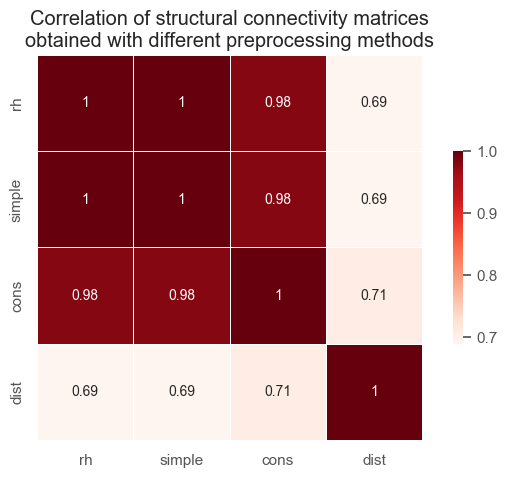

In [16]:
labels = ["rh","simple","cons","dist"]
sns.heatmap(df_weights.corr(method='spearman'), cmap="Reds",vmax=1, vmin=min(correlations["r"]),
            square=True, linewidths=.5, cbar_kws={"shrink": .5},annot=True,xticklabels=labels,yticklabels=labels)
plt.title("Correlation of structural connectivity matrices\nobtained with different preprocessing methods")
plt.savefig(paths.path_figures(fig_dir+"correlations_prep_methods.pdf"))


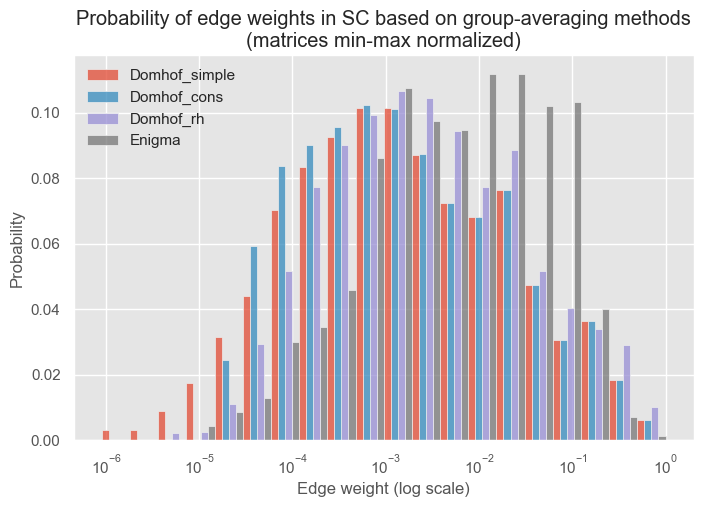

In [17]:
sns.histplot(df_weights_normalized,bins=20,log_scale=True,multiple="dodge",stat="probability",common_norm=False)
plt.xlabel("Edge weight (log scale)")
title = "Probability of edge weights in SC based on group-averaging methods\n(matrices min-max normalized)"
plt.title(title)
plt.savefig(paths.path_figures(fig_dir+"probab_edge_weights.pdf"),bbox_inches='tight',pad_inches=0)

<Axes: ylabel='Probability'>

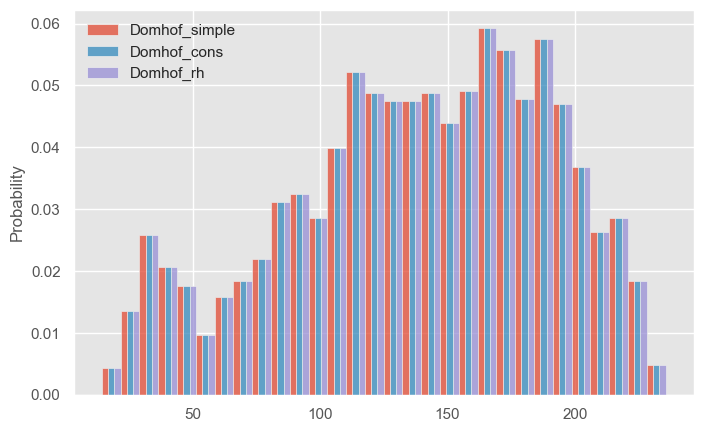

In [18]:
sns.histplot(df_lengths,bins=30,multiple="dodge",stat="probability",common_norm=False)

In [19]:
# the coordinates are not in MNI space, so we shift them manually for plotting reasons
centroids_shifted = centroid_coors
for i in range(3):
    centroids_shifted[:,i] = centroid_coors[:,i] - ((centroid_coors[:,i].max()-centroid_coors[:,i].min())/2+centroid_coors[:,i].min())
centroids_shifted[:,1]-=12
centroids_shifted[:,2]+=15

NameError: name 'centroids' is not defined

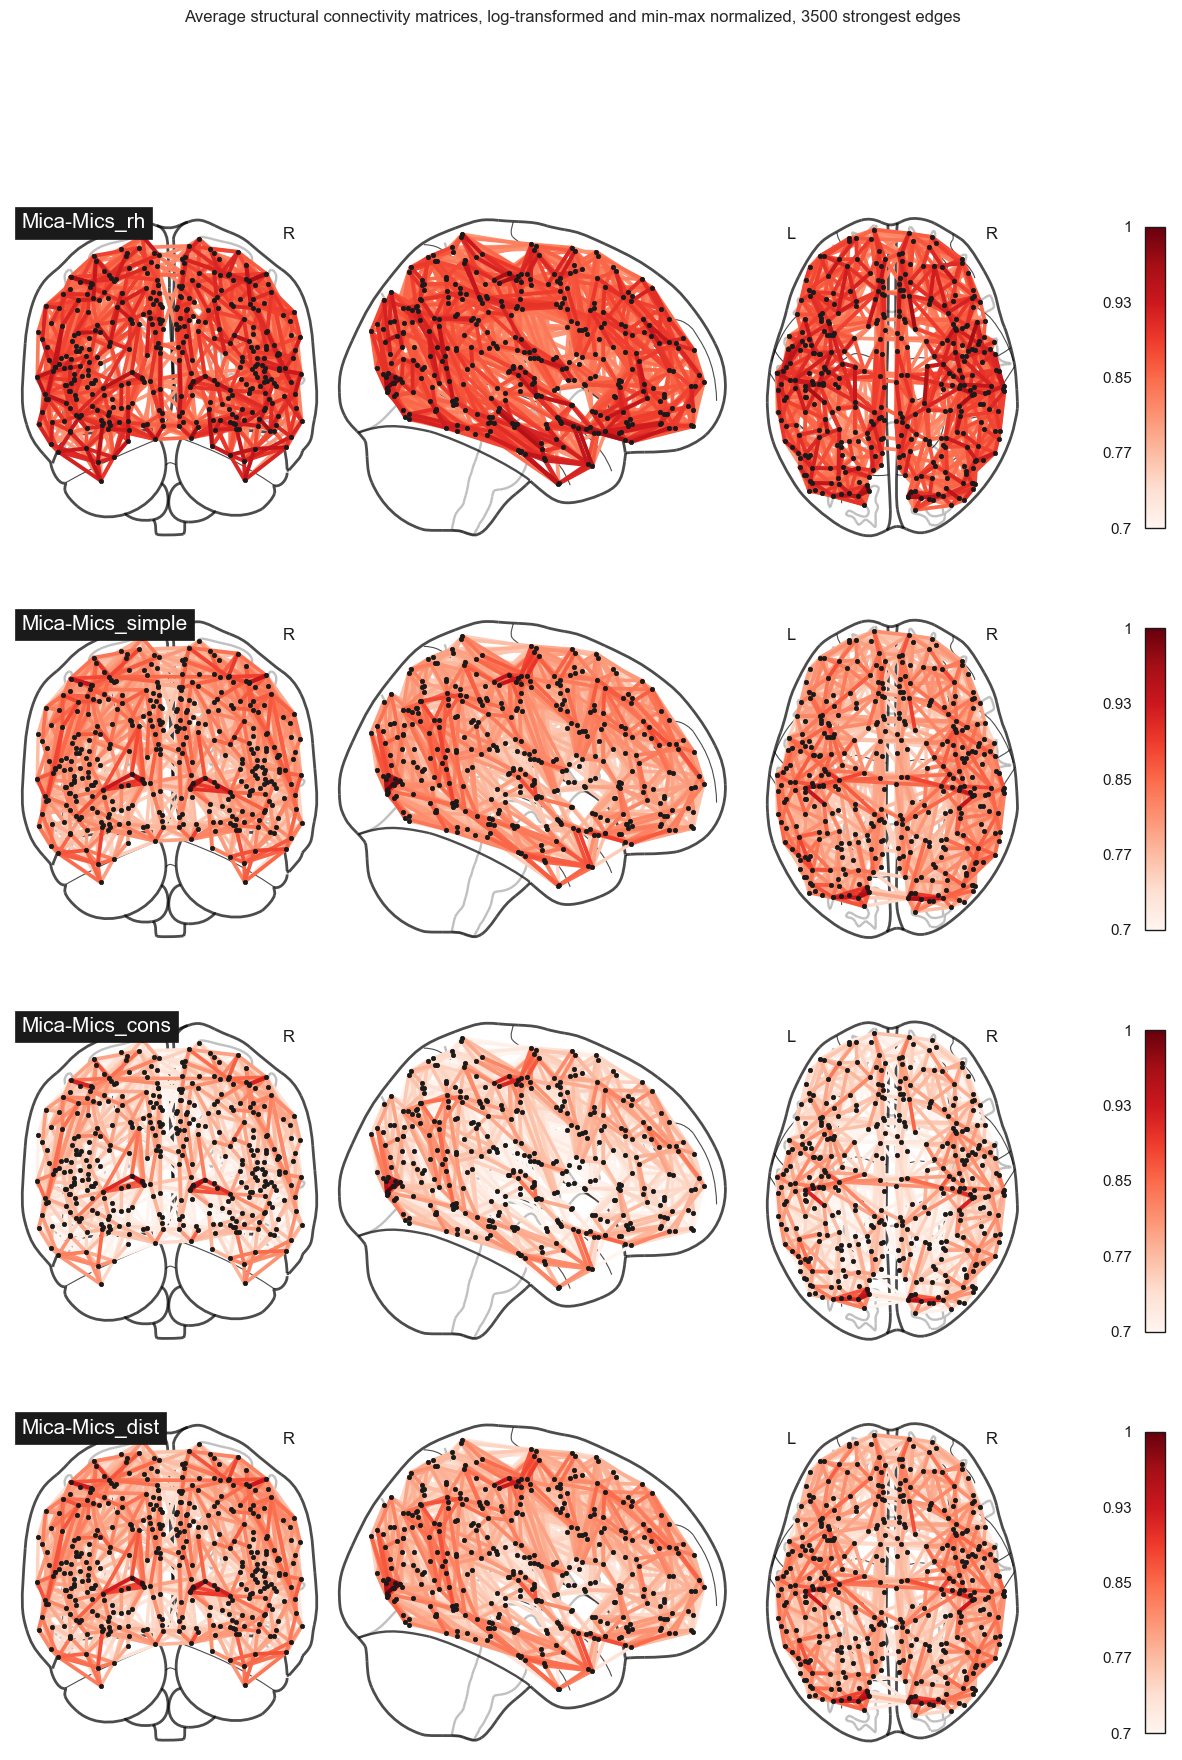

In [ ]:
fig, ax= plt.subplots(len(SC_matrices),1,figsize=(15,len(SC_matrices)*5),sharex=True,sharey=True)
n_edges = 3500

fig.suptitle(f"Average structural connectivity matrices, log-transformed and min-max normalized, {n_edges} strongest edges")

for i,d in enumerate(SC_matrices):
    name, SC_W, _, SC_W_log = d
    m = np.nan_to_num(SC_W_log,nan=np.nan,posinf=np.nan,neginf=np.nan)

    m = (m - np.nanmin(m,axis=None))
    m = m/np.nanmax(m,axis=None)

    np.fill_diagonal(m,0)
    pivot = data.find_pivot_to_keep_x_edges(m,x=n_edges)
    m = np.where(m>pivot,m,0)

    plotting.plot_connectome(m,centroids_shifted,axes=ax[i],node_color="k",node_size=10,title=name,colorbar=True,edge_cmap='Reds',edge_vmin=0.7,edge_vmax=1)

plt.savefig(paths.path_figures(fig_dir+"connectomes_brain.pdf"))